## Introduction to ICESat-2 Surface Velocity Calculations

This notebook is meant to introduce the processing flow for a simple along-track velocity calculation using repeat cycles of ICESat-2 elevation profiles. The notebook covers:
1. Setting up the IS2_velocity library
2. Loading elevation data from an hdf5 file using the built-in reader function.
3. Smoothing and differentiating the elevation profile.
4. Correlating the differentiated profile to calculate surface velocities.

In [1]:
# This cell: put the versions of codes I'm working on first in path
import sys
print(sys.path)
working_module_directory = '/Users/grace/Dropbox/Cornell/projects/003/git_repo'
if not sys.path[0] == working_module_directory:
    sys.path.insert(0, working_module_directory)
print(sys.path)

['/Users/grace/Dropbox/Cornell/projects/003/git_repo/notebooks', '/Users/grace/anaconda3/envs/icesat2020/lib/python37.zip', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/lib-dynload', '', '/Users/grace/.local/lib/python3.7/site-packages', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/site-packages', '/Users/grace/Dropbox/Cornell/projects/003/icepyx_20200722/icepyx', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/site-packages/IS2_velocity-0.0.1-py3.7.egg', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/site-packages/cligj-0.7.0-py3.7.egg', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/site-packages/appdirs-1.4.4-py3.7.egg', '/Users/grace/anaconda3/envs/icesat2020/lib/python3.7/site-packages/IPython/extensions', '/Users/grace/.ipython']
['/Users/grace/Dropbox/Cornell/projects/003/git_repo', '/Users/grace/Dropbox/Cornell/projects/003/git_repo/notebooks', '/Users/grace/anaconda3/envs/icesat2020/l

In [2]:
# Import the basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

## Library Setup

In order to run the IS2_velocity scripts as a python library, you must first:
1. Download or clone the repository at https://github.com/ICESAT-2HackWeek/IS2_velocity.git
2. Install the dependencies including numpy, scipy, h5py, astropy, icepyx, and the ICESat-2 pointCollection library.
3. Go the the home directory in our repository and run ‘python setup.py install’.

If you successfully run the setup.py script, you should be able to run the cell below.

In [3]:
# As an example, import a function from the ICESat-2 surface velocity library
from IS2_velocity.correlation_processing import calculate_velocities

## Load data

In [4]:
from IS2_velocity.readers_atl06 import load_data_by_rgt

# path to data, relative to folder /notebooks
data_dir = '../data/'
rgt = '0848'

# Load data; This step loads raw data, interpolates to constant spacing, filters if requested, and 
# differentiates
filter_type = 'running_average'
running_avg_window = 100

data = load_data_by_rgt(rgt, data_dir, product = 'ATL06',format = 'hdf5')

Loaded data from cycles: 03,04 for rgt: 0848


## Visualize one of the beams

<IPython.core.display.Javascript object>


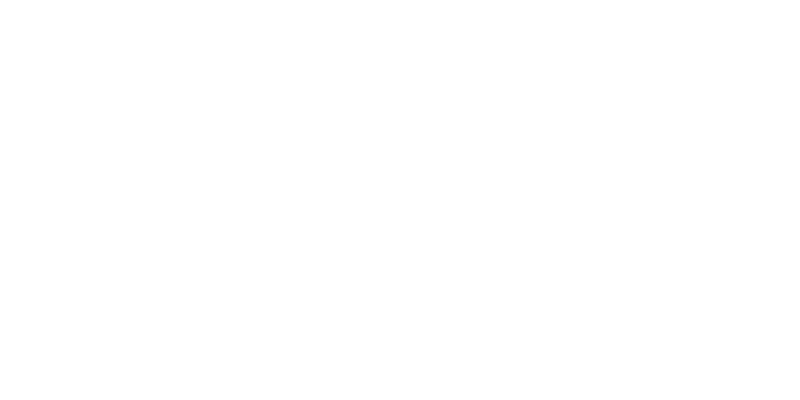

In [5]:
# Plot the landice elevation along the pass.

cycle1='03'
cycle2='04'
beam='gt1l'

plt.figure(figsize=(8,4))

plt.plot(data['x_atc'][cycle1][beam]/1000.,data['h_li'][cycle1][beam],c='indianred')
plt.plot(data['x_atc'][cycle2][beam]/1000.,data['h_li'][cycle2][beam],c='steelblue')
plt.ylabel('Elevation (m)')
plt.xlabel('Along-Track Distance (km)')

plt.tight_layout()

## Preprocessing

In [6]:
from IS2_velocity.preprocessing import *

data = fill_seg_ids(data)
data = interpolate_nans(data)
data = filt(data)
data = differentiate(data)

## Calculate velocity between cycles 03 and 04

In [7]:
from IS2_velocity.correlation_processing import calculate_velocities

# Calculate velocity between cycles 3 and 4
cycle1 = '03'
cycle2 = '04'
beams = ['gt1l','gt1r','gt2l','gt2r','gt3l','gt3r']

data = calculate_velocities(data, cycle1, cycle2, beams)

## Save result

In [8]:
from IS2_velocity.saving import *

write_out_path = './'
write_out_prefix = ''
map_data_root = '/Users/grace/Dropbox/Cornell/projects/003/FIS_data/' # where map data are stored; different on each computer
spatial_extent = np.array([-65, -86, -55, -81])

product = 'ATL06'

dx = 20
segment_length = 2000
search_width = 1000
along_track_step = 100
max_percent_nans = 10

save_is2_velocity(data,rgt,write_out_path,write_out_prefix,product,map_data_root,
                     cycle1,cycle2,dx,segment_length,search_width,along_track_step,
                     max_percent_nans,spatial_extent)

## Visualize result for one beam 

<IPython.core.display.Javascript object>


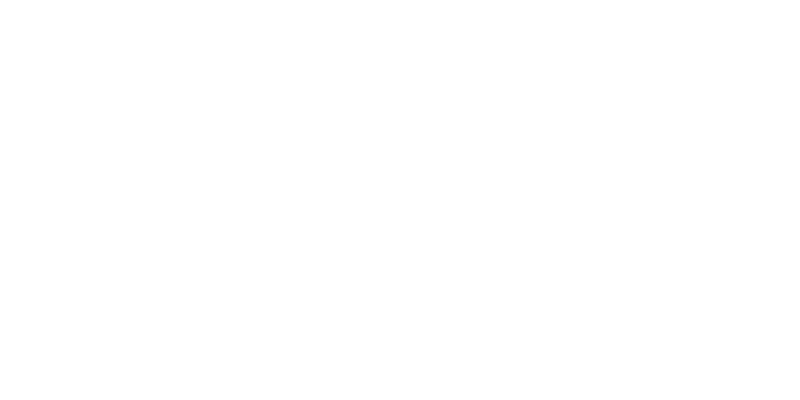

In [9]:
from matplotlib.gridspec import GridSpec

beam = 'gt1r'
x1 = data['x_atc'][cycle1][beam]
x2 = data['x_atc'][cycle2][beam]
h1 = data['h_li'][cycle1][beam]
h2 = data['h_li'][cycle2][beam]
dh1 = data['h_li_diff'][cycle1][beam]
dh2 = data['h_li_diff'][cycle2][beam]
vel_xs = data['midpoints_x_atc'][beam]
velocs = data['velocities'][beam]
correlation_vals = data['correlations'][beam]


plt.figure(figsize=(8,4))
gs = GridSpec(2,2)

# Plot the elevation profiles again
plt.subplot(gs[0,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,h1,'.',c='indianred')
plt.plot(x2/1000.-29000,h2,'.',c='steelblue',ms=3)
plt.ylabel('Elevation (m)')
plt.title('ATL06',fontweight='bold')
plt.xlim(80,580)

# Plot the slopes again
plt.subplot(gs[1,0])
plt.tick_params(bottom=False,labelbottom=False)
plt.plot(x1/1000.-29000,dh1,'.',c='indianred')
plt.plot(x2/1000.-29000,dh2,'.',c='steelblue',ms=3)
plt.ylim(-.05,.05)
plt.ylabel('Surface Slope (m/m)')
plt.xlim(80,580)

# Plot the calculated velocities along track
ax5 = plt.subplot(gs[0,1])
# plt.plot(vel_xs/1000.-29000,velocs,'.',c='k',label='ATL06')
plt.scatter(vel_xs/1000.-29000,velocs,s=2,marker='.',c=correlation_vals,label='ATL06')
plt.ylabel('Velocity (m/yr)')
plt.xlabel('Along-Track Distance (km)')
plt.colorbar(label='Correlation coefficient')
plt.xlim(80,580)
plt.ylim(-500,1500)

plt.tight_layout()

<IPython.core.display.Javascript object>


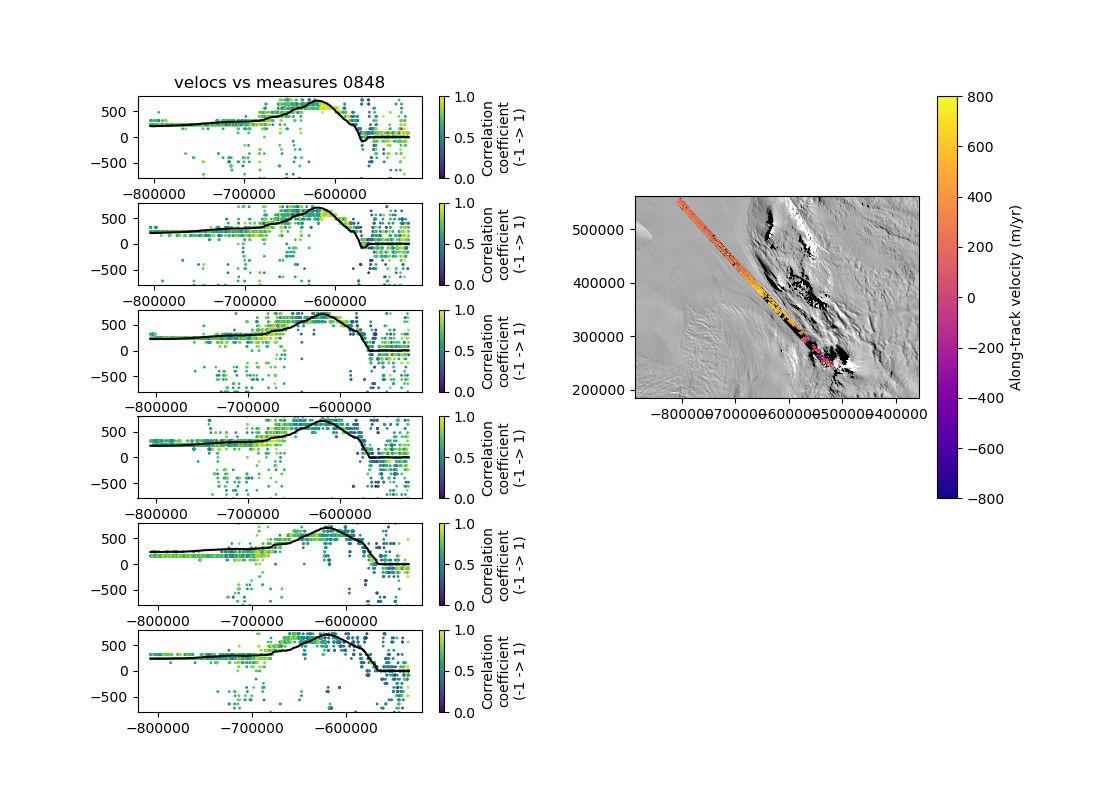

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([-887950., -356950.,  183825.,  561825.]), 'origin': 'lower'}


In [10]:
from IS2_velocity.plotting import plot_measures_along_track_comparison

map_data_root = '/Users/grace/Dropbox/Cornell/projects/003/FIS_data/' # where map data are stored; different on each computer
data_path = write_out_path # where data were written out in above step
plot_out_location = '.' # where to save figure

correlation_threshold = 0.65
velocity_number = 0
spatial_extent = np.array([-65, -86, -55, -81])
epsg = 3031

plot_measures_along_track_comparison(rgt, beams, data_path, correlation_threshold, spatial_extent, plot_out_location, map_data_root, velocity_number, epsg)

# Visualize correlation functions

<IPython.core.display.Javascript object>


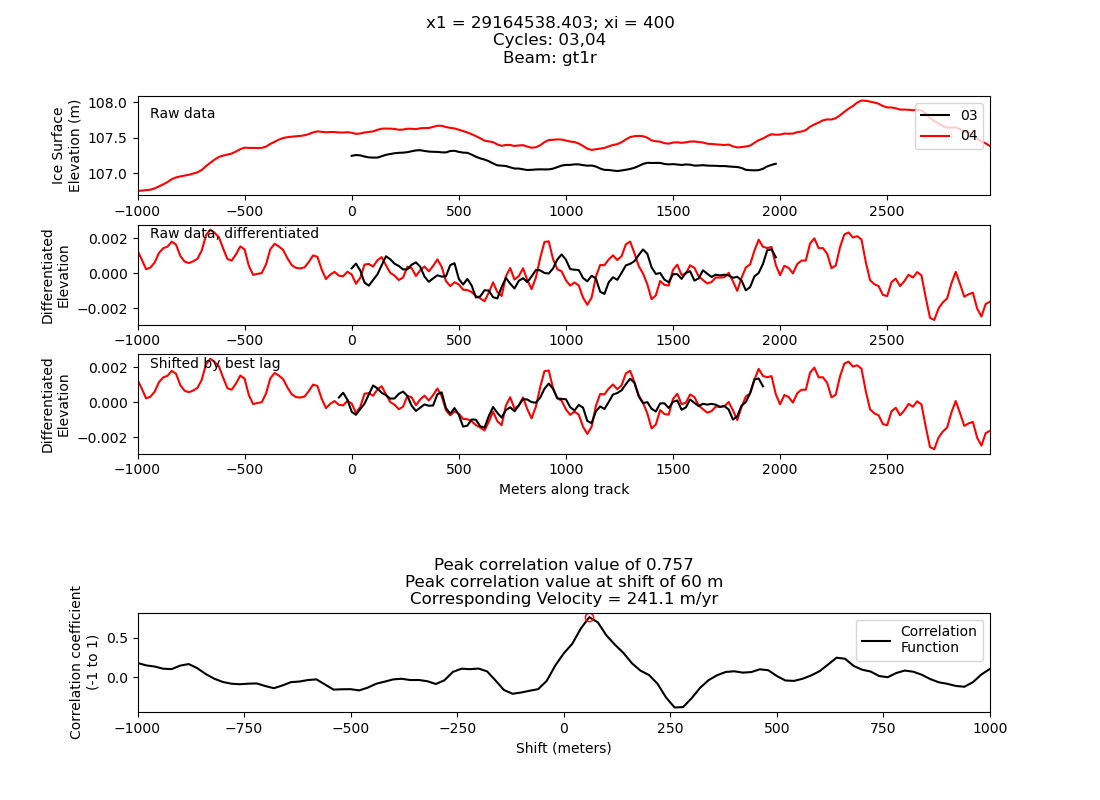

<IPython.core.display.Javascript object>


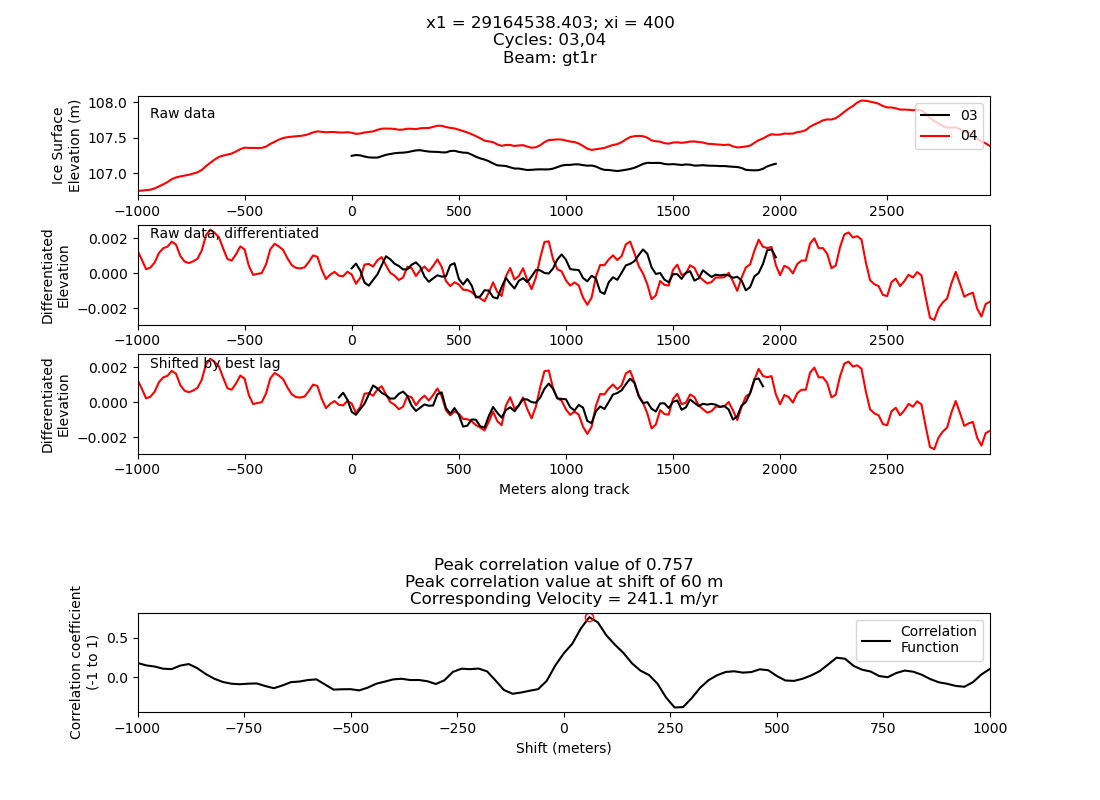

In [11]:
from IS2_velocity.correlation_processing import determine_x1s
from IS2_velocity.plotting import plot_correlation_function

x1s = determine_x1s(data, cycle1, cycle2, beam, search_width=search_width, segment_length=segment_length,
                                    along_track_step=along_track_step, dx=dx)

# Pick a value of x1 to plot the correlation function for
x1 = x1s[400]
plot_correlation_function(x1, data, cycle1, cycle2, beam, search_width=1000, segment_length=2000, along_track_step=100,
                                    max_percent_nans=10, dx=20)


In [12]:
x1


29164538.40319396